# Long Short Term Memory Networks for IoT Prediction

GitHub link: https://github.com/psenrique/AAI530_ASSIGNMENT4

RNNs and LSTM models are very popular neural network architectures when working with sequential data, since they both carry some "memory" of previous inputs when predicting the next output. In this assignment we will continue to work with the Household Electricity Consumption dataset and use an LSTM model to predict the Global Active Power (GAP) from a sequence of previous GAP readings. You will build one model following the directions in this notebook closely, then you will be asked to make changes to that original model and analyze the effects that they had on the model performance. You will also be asked to compare the performance of your LSTM model to the linear regression predictor that you built in last week's assignment.

In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.utils import pad_sequences

In [2]:
#use this cell to import additional libraries or define helper functions

## Load and prepare your data

We'll once again be using the cleaned household electricity consumption data from the previous two assignments. I recommend saving your dataset by running df.to_csv("filename") at the end of assignment 2 so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

Unlike when using Linear Regression to make our predictions for Global Active Power (GAP), LSTM requires that we have a pre-trained model when our predictive software is shipped (the ability to iterate on the model after it's put into production is another question for another day). Thus, we will train the model on a segment of our data and then measure its performance on simulated streaming data another segment of the data. Our dataset is very large, so for speed's sake, we will limit ourselves to 1% of the entire dataset.

**TODO: Import your data, select the a random 1% of the dataset, and then split it 80/20 into training and validation sets (the test split will come from the training data as part of the tensorflow LSTM model call). HINT: Think carefully about how you do your train/validation split--does it make sense to randomize the data?**

In [3]:
#Load your data into a pandas dataframe here
df = pd.read_csv('AAI530_ASSIGNMENT2_DATA.csv')

In [4]:
#create your training and validation sets here
data =df['Global_active_power'].values.astype('float32')
data = np.reshape(data, (len(data), 1))
#assign size for data subset
size = round(len(data)*0.01)
#take random data subset
data = data[0:size]
#split data subset 80/20 for train/validation
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train_df = pd.DataFrame(data[0:train_size,:])
val_df = pd.DataFrame(data[train_size:len(data),:])

In [5]:
#reset the indices for cleanliness
train_df = train_df.reset_index()
train_df.columns = ['index','Global_active_power']
val_df = val_df.reset_index()
val_df.columns = ['index','Global_active_power']

Next we need to create our input and output sequences. In the lab session this week, we used an LSTM model to make a binary prediction, but LSTM models are very flexible in what they can output: we can also use them to predict a single real-numbered output (we can even use them to predict a sequence of outputs). Here we will train a model to predict a single real-numbered output such that we can compare our model directly to the linear regression model from last week.

**TODO: Create a nested list structure for the training data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output**

In [6]:
seq_arrays = []
seq_labs = []

In [7]:
# we'll start out with a 30 minute input sequence and a 5 minute predictive horizon
# we don't need to work in seconds this time, since we'll just use the indices instead of a unix timestamp
seq_length = 30
ph = 5

feat_cols = ['Global_active_power']

#create list of sequence length GAP readings
num_rows = len(train_df)

for i in range(0,num_rows-seq_length-ph):
 seq_arrays.append(train_df[feat_cols].iloc[i:i+seq_length].to_numpy())
 seq_labs.append(train_df['Global_active_power'].iloc[i+ph])


#convert to numpy arrays and floats to appease keras/tensorflow
seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [8]:
assert(seq_arrays.shape == (len(train_df)-seq_length-ph,seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph,))

In [9]:
seq_arrays.shape

(16359, 30, 1)

**Q: What is the function of the assert statements in the above cell? Why do we use assertions in our code?**

A: The assert functions act as a boolean check point to ensure that the statement is True. If it is the code continues to be executed, and if it is False the function throws an error, and the code stops executing. In this instance it is used to verify that the shape of seq_arrays is (16359,30,1) and the shape of seq_labs is (16359,).

## Model Training

We will begin with a model architecture very similar to the model we built in the lab session. We will have two LSTM layers, with 5 and 3 hidden units respectively, and we will apply dropout after each LSTM layer. However, we will use a LINEAR final layer and MSE for our loss function, since our output is continuous instead of binary.

**TODO: Fill in all values marked with a ?? in the cell below**

In [10]:
# define path to save model
model_path = 'LSTM_model1.h5'

# build the network
nb_features = seq_arrays.shape[2]
nb_out = seq_labs.shape[0]

model = Sequential()

#add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=5,
         return_sequences=True))
model.add(Dropout(0.2))

# add second LSTM layer
model.add(LSTM(
          units=3,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation('linear'))
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

print(model.summary())

# fit the network
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 5)             140       
                                                                 
 dropout (Dropout)           (None, 30, 5)             0         
                                                                 
 lstm_1 (LSTM)               (None, 3)                 108       
                                                                 
 dropout_1 (Dropout)         (None, 3)                 0         
                                                                 
 dense (Dense)               (None, 16359)             65436     
                                                                 
 activation (Activation)     (None, 16359)             0         
                                                                 
Total params: 65684 (256.58 KB)
Trainable params: 65684 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


32/32 - 0s - loss: 2.1059 - mse: 2.1059 - val_loss: 0.2918 - val_mse: 0.2918 - 311ms/epoch - 10ms/step
Epoch 3/100
32/32 - 0s - loss: 1.2332 - mse: 1.2332 - val_loss: 0.0651 - val_mse: 0.0651 - 293ms/epoch - 9ms/step
Epoch 4/100
32/32 - 0s - loss: 0.8851 - mse: 0.8851 - val_loss: 0.0558 - val_mse: 0.0558 - 299ms/epoch - 9ms/step
Epoch 5/100
32/32 - 0s - loss: 0.7551 - mse: 0.7551 - val_loss: 0.0830 - val_mse: 0.0830 - 274ms/epoch - 9ms/step
Epoch 6/100
32/32 - 0s - loss: 0.6937 - mse: 0.6937 - val_loss: 0.0704 - val_mse: 0.0704 - 259ms/epoch - 8ms/step
Epoch 7/100
32/32 - 0s - loss: 0.6337 - mse: 0.6337 - val_loss: 0.0553 - val_mse: 0.0553 - 297ms/epoch - 9ms/step
Epoch 8/100
32/32 - 0s - loss: 0.6037 - mse: 0.6037 - val_loss: 0.0554 - val_mse: 0.0554 - 286ms/epoch - 9ms/step
Epoch 9/100
32/32 - 0s - loss: 0.5971 - mse: 0.5971 - val_loss: 0.0519 - val_mse: 0.0519 - 294ms/epoch - 9ms/step
Epoch 10/100
32/32 - 0s - loss: 0.5597 - mse: 0.5597 - val_loss: 0.0516 - val_mse: 0.0516 - 296ms/e

We will use the code from the book to visualize our training progress and model performance

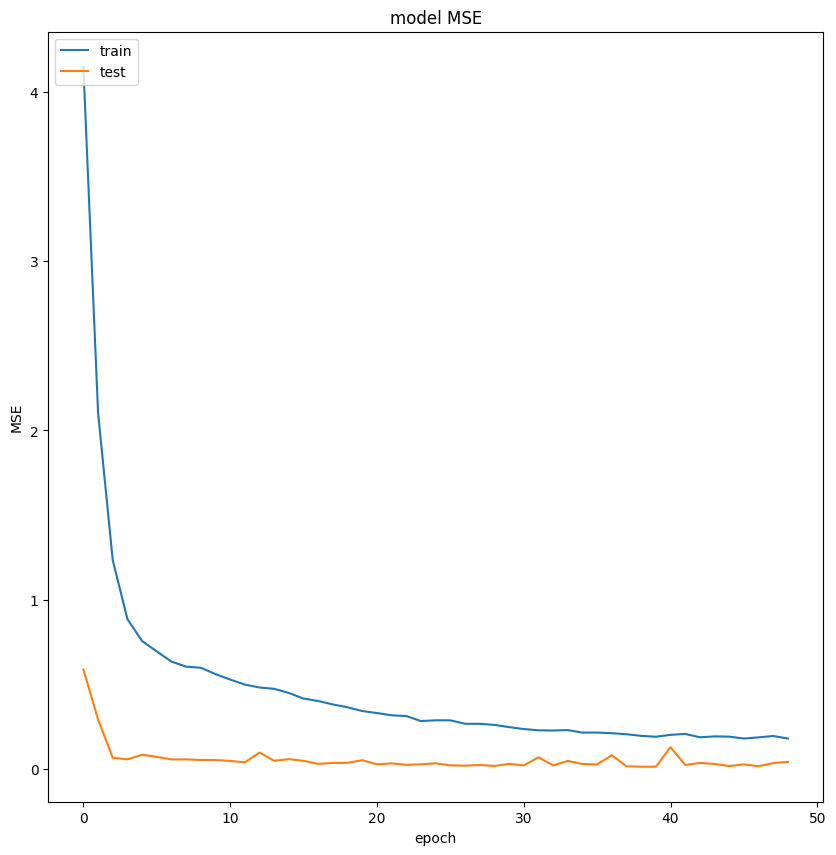

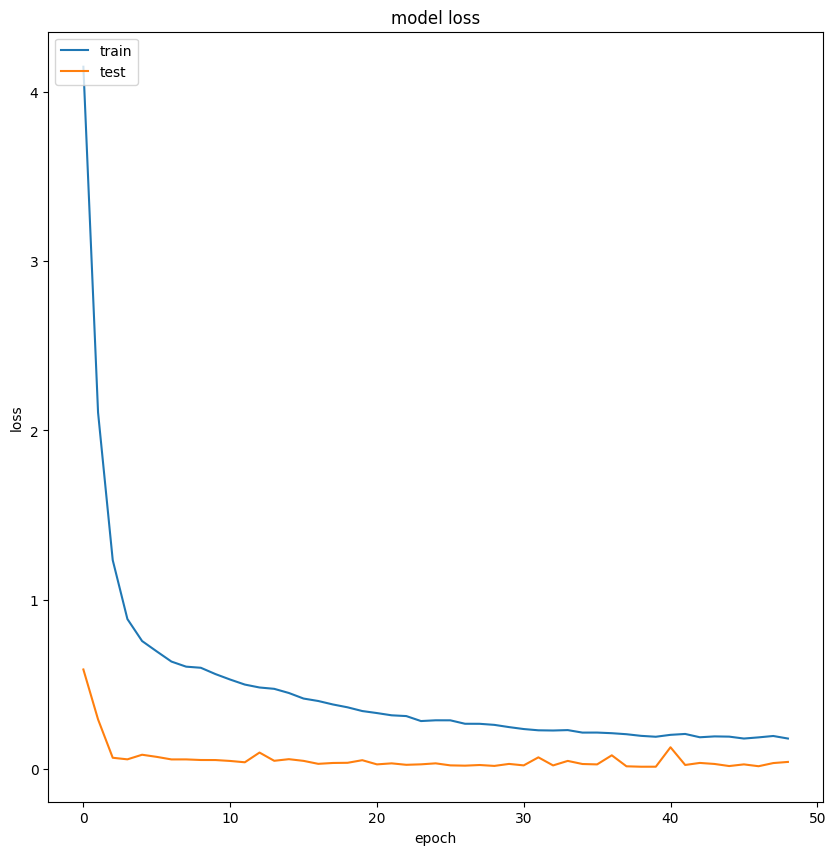

In [11]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_mse1.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")


## Validating our model

Now we need to create our simulated streaming validation set to test our model "in production". With our linear regression models, we were able to begin making predictions with only two datapoints, but the LSTM model requires an input sequence of *seq_length* to make a prediction. We can get around this limitation by "padding" our inputs when they are too short.

**TODO: create a nested list structure for the validation data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output. Begin your predictions after only two GAP measurements are available, and check out [this keras function](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) to automatically pad sequences that are too short.**

**Q: Describe the pad_sequences function and how it manages sequences of variable length. What does the "padding" argument determine, and which setting makes the most sense for our use case here?**

A: The pad_sequence function changes a list of integers into a 2D Numpy array with a length of either a specified amount or the length of the longest sequence in the list. This is completed by adding a value that can be specified in the value parameter or the default value of 0.0. The padding parameter determines where in the sequence the padding values are placed, either before or after each sequence. For this application, adding the padding before the sequence makes the most sense since it is time series data and adding the padding after the sequence will change the trend.

In [12]:
val_arrays = []
val_labs = []

#create list of GAP readings starting with a minimum of two readings
num_rows = len(val_df)

for i in range(2,num_rows-ph):
  if i<seq_length:
    val_arrays.append(val_df[feat_cols].iloc[:i])
  else:
    val_arrays.append(val_df[feat_cols].iloc[i-seq_length:i])
  val_labs.append(val_df['Global_active_power'].iloc[i+ph])

# use the pad_sequences function on your input sequences
# remember that we will later want our datatype to be np.float32
val_arrays = pad_sequences(val_arrays,maxlen=seq_length,padding='pre')
val_arrays = np.array(val_arrays, dtype = object).astype(np.float32)
#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)


We will now run this validation data through our LSTM model and visualize its performance like we did on the linear regression data.

128/128 - 1s - loss: 2.0296 - mse: 2.0296 - 536ms/epoch - 4ms/step

MSE: 2.0295820236206055
128/128 [==============================] - 2s 4ms/step


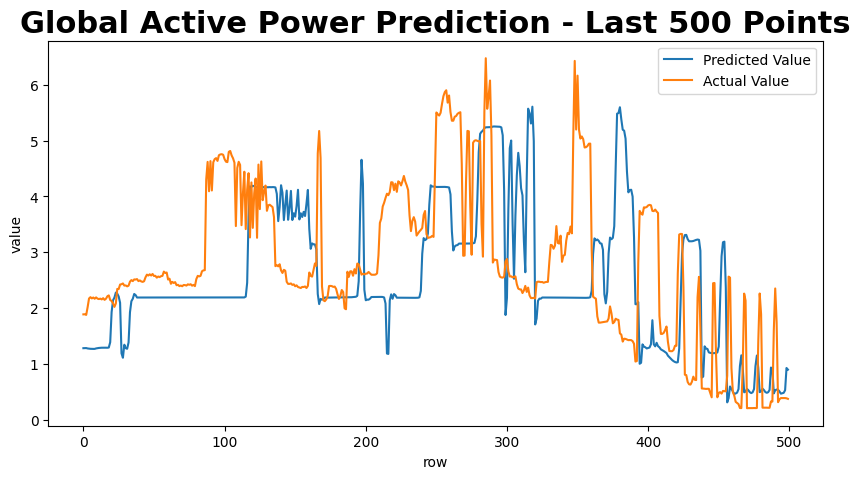

In [13]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[:,0][-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

**Q: How did your model perform? What can you tell about the model from the loss curves? What could we do to try to improve the model?**

A: Based on the MSE and the loss values, the model preformed decently but has room for improvement. From the loss curve it can be seen that the model converges and is able to learn and improve over time. The test loss remains below the training loss indicating that no overfitting is occurring. To improve the model, fine tuning of the hyperparameters can be completed, the predictive horizon can be shortened, or additional hidden layers can be added to the model.


## Model Optimization

Now it's your turn to build an LSTM-based model in hopes of improving performance on this training set. Changes that you might consider include:

- Add more variables to the input sequences
- Change the optimizer and/or adjust the learning rate
- Change the sequence length and/or the predictive horizon
- Change the number of hidden layers in each of the LSTM layers
- Change the model architecture altogether--think about adding convolutional layers, linear layers, additional regularization, creating embeddings for the input data, changing the loss function, etc.

There isn't any minimum performance increase or number of changes that need to be made, but I want to see that you have tried some different things. Remember that building and optimizing deep learning networks is an art and can be very difficult, so don't make yourself crazy trying to optimize for this assignment.

**Q: What changes are you going to try with your model? Why do you think these changes could improve model performance?**

A: The first change that will be implemented is a shorter predictive horizon. Since the GAP data varies significantly from minute to minute, a shorter predictive horizon may be better at predicting these variances. The second change to the model is hyperparameter tuning such as the units in each LSTM layer, the activation function, and the learning rate. Hyperparameters control the model structure, function, and performance and tuning them allows for optimizing the performance.

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 30, 5)             140       
                                                                 
 dropout_6 (Dropout)         (None, 30, 5)             0         
                                                                 
 lstm_7 (LSTM)               (None, 3)                 108       
                                                                 
 dropout_7 (Dropout)         (None, 3)                 0         
                                                                 
 dense_3 (Dense)             (None, 16363)             65452     
                                                                 
 activation_3 (Activation)   (None, 16363)             0         
                                                                 
Total params: 65700 (256.64 KB)
Trainable params: 6570

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


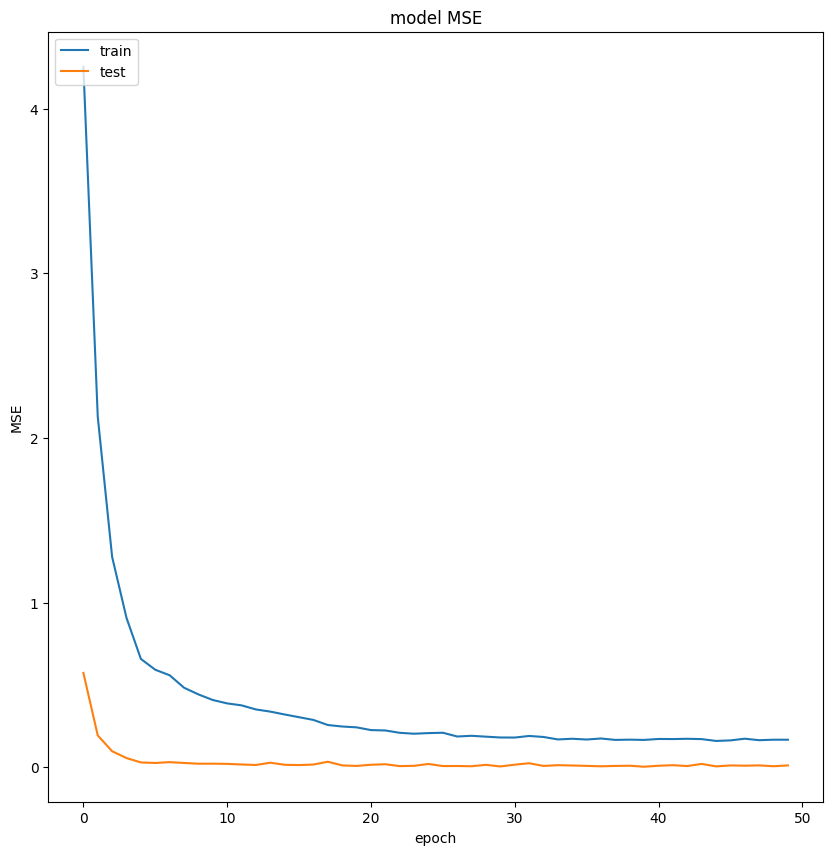

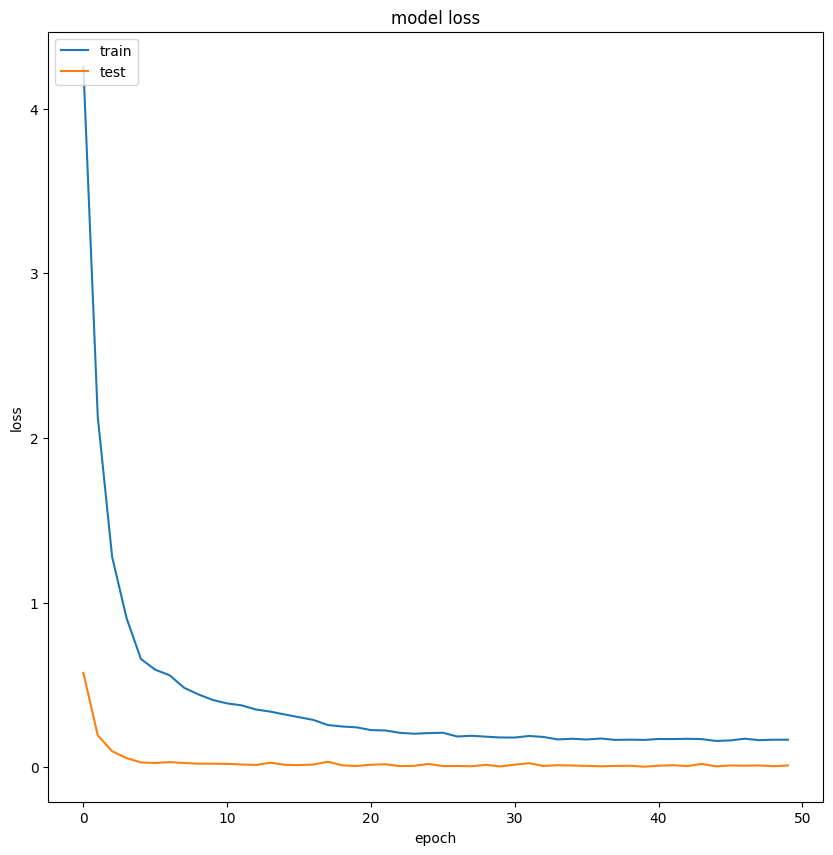

In [18]:
## Decrease predictive horizon
# play with your ideas for optimization here
seq_arrays = []
seq_labs = []

# we'll start out with a 30 minute input sequence and a 5 minute predictive horizon
# we don't need to work in seconds this time, since we'll just use the indices instead of a unix timestamp
seq_length = 30
ph = 1

feat_cols = ['Global_active_power']

#create list of sequence length GAP readings
num_rows = len(train_df)

for i in range(0,num_rows-seq_length-ph):
 seq_arrays.append(train_df[feat_cols].iloc[i:i+seq_length].to_numpy())
 seq_labs.append(train_df['Global_active_power'].iloc[i+ph])


#convert to numpy arrays and floats to appease keras/tensorflow
seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)
# define path to save model
model_path = 'LSTM_model2.h5'

# build the network
nb_features = seq_arrays.shape[2]
nb_out = seq_labs.shape[0]

model = Sequential()

#add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=5,
         return_sequences=True))
model.add(Dropout(0.2))

# add second LSTM layer
model.add(LSTM(
          units=3,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation('linear'))
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

print(model.summary())

# fit the network
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=0,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_mse2.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss2.png")

128/128 - 0s - loss: 2.1551 - mse: 2.1551 - 407ms/epoch - 3ms/step

MSE: 2.1551384925842285
128/128 [==============================] - 1s 3ms/step


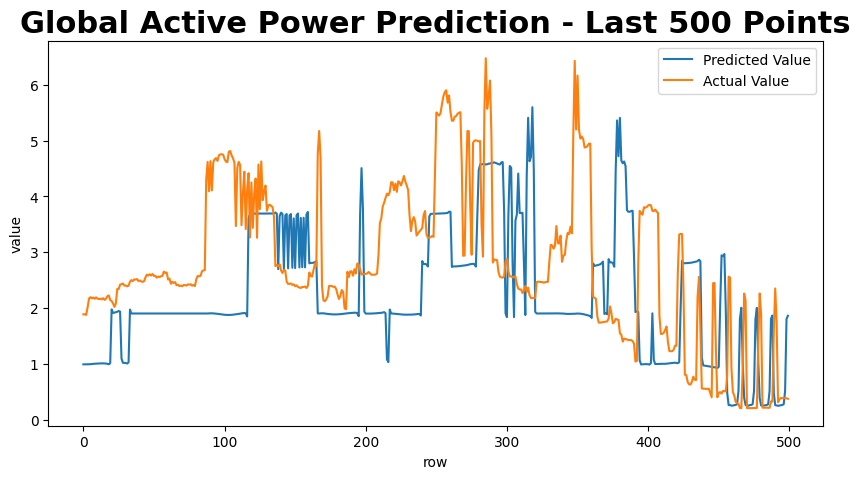

In [19]:
# show me how one or two of your different models perform
# using the code from the "Validating our model" section above
val_arrays = []
val_labs = []

#create list of GAP readings starting with a minimum of two readings
num_rows = len(val_df)

for i in range(2,num_rows-ph):
  if i<seq_length:
    val_arrays.append(val_df[feat_cols].iloc[:i])
  else:
    val_arrays.append(val_df[feat_cols].iloc[i-seq_length:i])
  val_labs.append(val_df['Global_active_power'].iloc[i+ph])

# use the pad_sequences function on your input sequences
# remember that we will later want our datatype to be np.float32
val_arrays = pad_sequences(val_arrays,maxlen=seq_length,padding='pre')
val_arrays = np.array(val_arrays, dtype = object).astype(np.float32)
#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[:,0][-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify1.png")

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 30, 5)             140       
                                                                 
 dropout_12 (Dropout)        (None, 30, 5)             0         
                                                                 
 lstm_13 (LSTM)              (None, 3)                 108       
                                                                 
 dropout_13 (Dropout)        (None, 3)                 0         
                                                                 
 dense_6 (Dense)             (None, 16359)             65436     
                                                                 
 activation_6 (Activation)   (None, 16359)             0         
                                                                 
Total params: 65684 (256.58 KB)
Trainable params: 6568

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


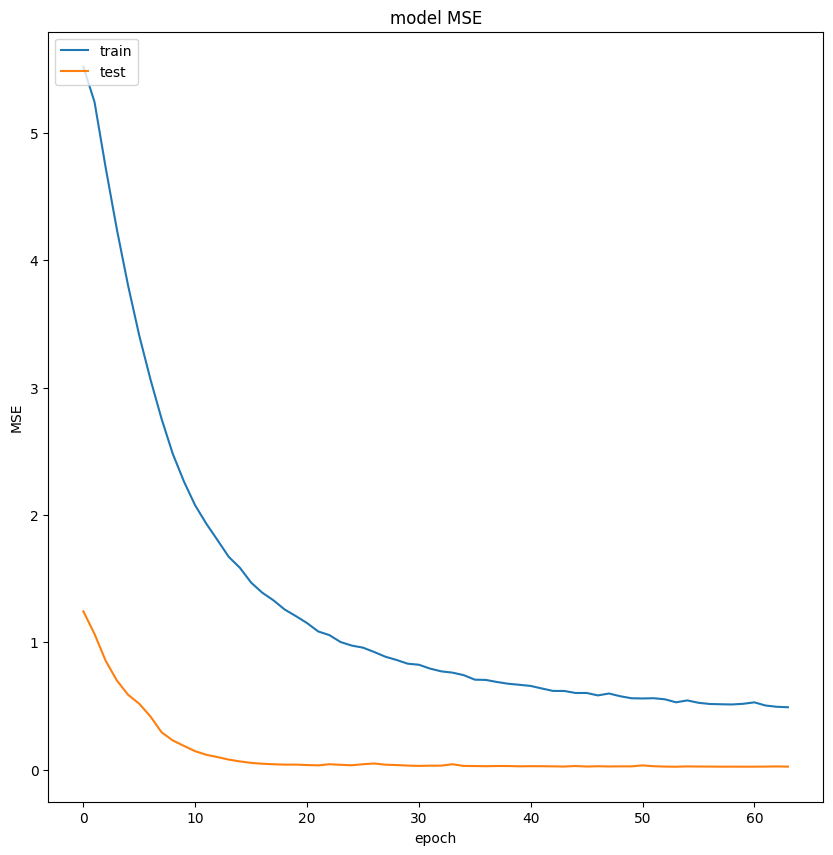

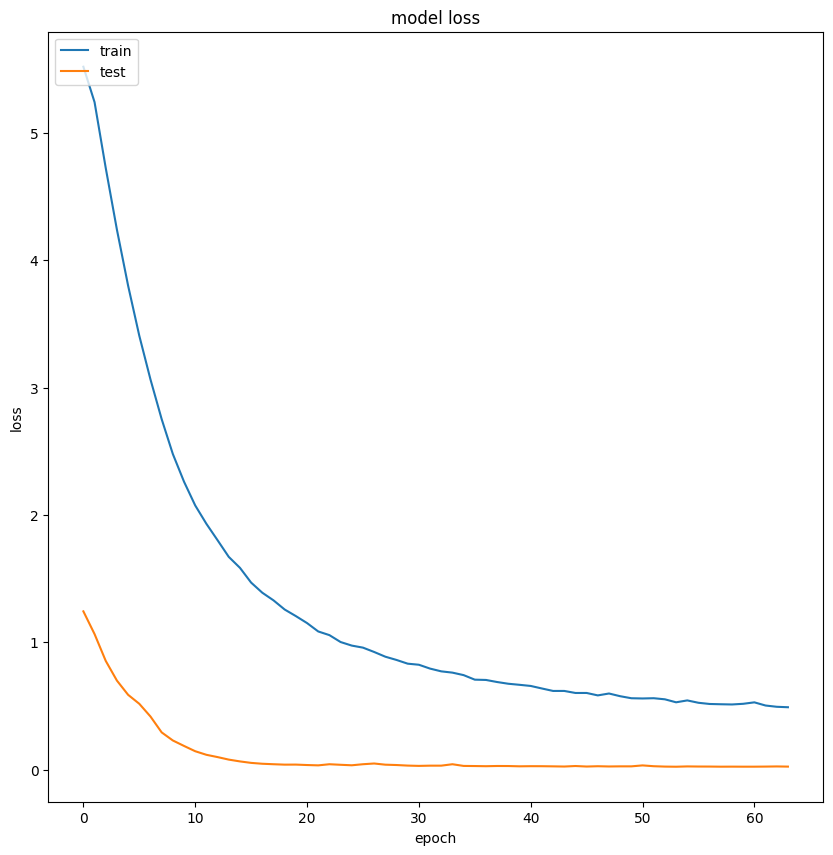

In [24]:
## Hyperparameter tuning
# play with your ideas for optimization here
seq_arrays = []
seq_labs = []

# we'll start out with a 30 minute input sequence and a 5 minute predictive horizon
# we don't need to work in seconds this time, since we'll just use the indices instead of a unix timestamp
seq_length = 30
ph = 5

feat_cols = ['Global_active_power']

#create list of sequence length GAP readings
num_rows = len(train_df)

for i in range(0,num_rows-seq_length-ph):
 seq_arrays.append(train_df[feat_cols].iloc[i:i+seq_length].to_numpy())
 seq_labs.append(train_df['Global_active_power'].iloc[i+ph])


#convert to numpy arrays and floats to appease keras/tensorflow
seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)
# define path to save model
model_path = 'LSTM_model3.h5'

# build the network
nb_features = seq_arrays.shape[2]
nb_out = seq_labs.shape[0]

model = Sequential()

#add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=5,
         return_sequences=True))
model.add(Dropout(0.2))

# add second LSTM layer
model.add(LSTM(
          units=3,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation('relu'))
optimizer = keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

print(model.summary())

# fit the network
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=0,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_mse3.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss3.png")

128/128 - 0s - loss: 1.8280 - mse: 1.8280 - 408ms/epoch - 3ms/step

MSE: 1.8280075788497925
128/128 [==============================] - 1s 3ms/step


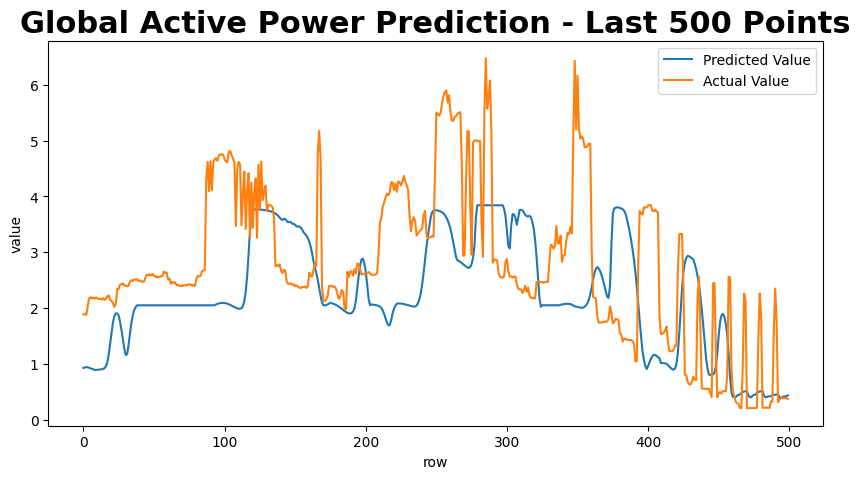

In [25]:
# show me how one or two of your different models perform
# using the code from the "Validating our model" section above
val_arrays = []
val_labs = []

#create list of GAP readings starting with a minimum of two readings
num_rows = len(val_df)

for i in range(2,num_rows-ph):
  if i<seq_length:
    val_arrays.append(val_df[feat_cols].iloc[:i])
  else:
    val_arrays.append(val_df[feat_cols].iloc[i-seq_length:i])
  val_labs.append(val_df['Global_active_power'].iloc[i+ph])

# use the pad_sequences function on your input sequences
# remember that we will later want our datatype to be np.float32
val_arrays = pad_sequences(val_arrays,maxlen=seq_length,padding='pre')
val_arrays = np.array(val_arrays, dtype = object).astype(np.float32)
#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[:,0][-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify3.png")

**Q: How did your model changes affect performance on the validation data? Why do you think they were/were not effective? If you were trying to optimize for production, what would you try next?**

A: Decreasing the predictive horizon from 5 to 1 results in the MSE value increasing from 2.030 to 2.1551, and the graphs reflect the model performance. This modification is ineffective in improving the model performance as the data is too complex to model using the current model hyperparameters.

Decreasing the model learning rate from 0.01 to 0.01 results in a performance improvement by reducing the MSE to 1.909. The performance of the model’s optimizer relies heavily on the learning rate and reducing the learning rate increases the time it takes converge to the solution leading to more accurate results. Further changing the activation function from a linear function to a rectified linear unit function further decreases the MSE to 1.828. This improvement is expected as the ReLu function introduces non-linearity to the model and is able to model more complex functions than a basic linear function. Changing the units in the LSTM hidden layers from 5 and 3 to 100 and 50 results in reduced loss in the training; however, the loss and MSE for the validation data worsens. This can be caused by overfitting to the training data and as a result the model is not able to generalize to data it has not seen before.  

To optimize for production the next steps would be to try the addition of LSTM hidden layers to see if the model is able to learn better and have a better performance on the validation data.



**Q: How did the models that you built in this assignment compare to the linear regression model from last week? Think about model performance and other IoT device considerations; Which model would you choose to use in an IoT system that predicts GAP for a single household with a 5-minute predictive horizon, and why?**

A: The linear regression models previously created generally outperform the deep learning models, especially the model using a moving average. To apply in a household, the linear regression model may be preferable as the performance is better and the model is simpler to implement. Even if the deep learning model is fine tuned to produce more accurate results, the application is not very critical, and the performance improvement may not outweigh the computational complexity.